In [152]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import pyhf
import eos
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from redist import modifier
from redist import plot
from pilnu.pilnu_utils import * 

# Reinterpreting $B \to \pi \tau \nu$ in terms of the WET

Here the differential branching ratio prediction is a function of two kinematic variables: $q^2$ and $\cos\theta_l$.

We use $q^2$ also as a fitting variable, but with a different binning than for the reweighting.

## Define the binning

In [153]:
fitbins = np.linspace( 3.40, 26.41, 8).tolist()
q2bins = np.linspace(  3.40, 26.41, 6).tolist()
ctbins = np.linspace( -1.00,  1.00, 5).tolist()
binning = [q2bins, ctbins]

bin_cents = np.add(fitbins[:-1], fitbins[1:])/2

## Define the NP model in WC space

In [154]:
cvl = 1.0
cvr = 0.
csl = 1.0
csr = 0.
ctl = 0.

## Generate some SM samples

In [155]:
SMsamples = 30000

p = eos.Parameters()
o = eos.Options({'form-factors': 'BSZ2015', 'l': 'tau', 'model':'WET'})
k = eos.Kinematics({
    'q2':            5.0,  'q2_min':            3.4,     'q2_max':           26.41,
    'cos(theta_l)':  0.0,  'cos(theta_l)_min': -1.0,      'cos(theta_l)_max': +1.0,
})

pdf = eos.SignalPDF.make('B->pilnu::d^2Gamma/dq2/dcos(theta_l)', p, k, o)
obs = eos.Observable.make('B->pilnu::BR', p, k, o)
SMBR = obs.evaluate()

null_samples, pdf_values = pdf.sample_mcmc(SMsamples, stride=5, pre_N=10000, preruns=5, cov_scale=0.1, rng=np.random.mtrand.RandomState(seed=1234))

Pre-runs:   0%|          | 0/5 [00:00<?, ?it/s]

Main run:   0%|          | 0/100 [00:00<?, ?it/s]

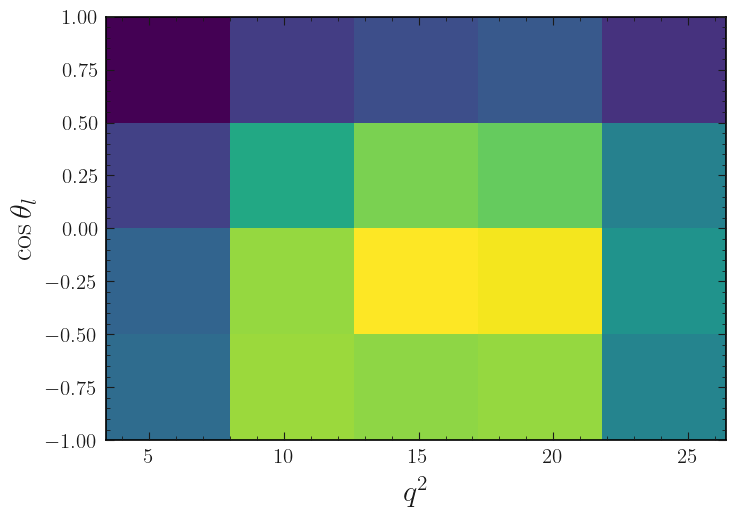

In [156]:
plt.hist2d(null_samples[:,0], null_samples[:,1], binning)
plt.xlabel(r'$q^2$')
plt.ylabel(r'$\cos\theta_l$')
plt.show()

## Smear samples with Gaussian resolution function and apply efficiency

In [157]:
null_q2 = null_samples[:,0]
null_ct = null_samples[:,1]

null_q2_smeared = np.random.normal(null_q2, 1.0, null_q2.shape)
#map values outside of range of q2bins to the closest boundary
null_q2_smeared = np.where(null_q2_smeared>max(q2bins), max(q2bins), null_q2_smeared)
null_q2_smeared = np.where(null_q2_smeared<min(q2bins), min(q2bins), null_q2_smeared)

null_ct_smeared = np.random.normal(null_ct, 0.1, null_ct.shape)
#map values outside of range of ctbins to the other side
null_ct_smeared = np.where(null_ct_smeared>max(ctbins), null_ct_smeared-(max(ctbins)-min(ctbins)), null_ct_smeared)
null_ct_smeared = np.where(null_ct_smeared<min(ctbins), null_ct_smeared+(max(ctbins)-min(ctbins)), null_ct_smeared)
null_samples_smeared = np.stack((null_q2_smeared, null_ct_smeared), axis=1)

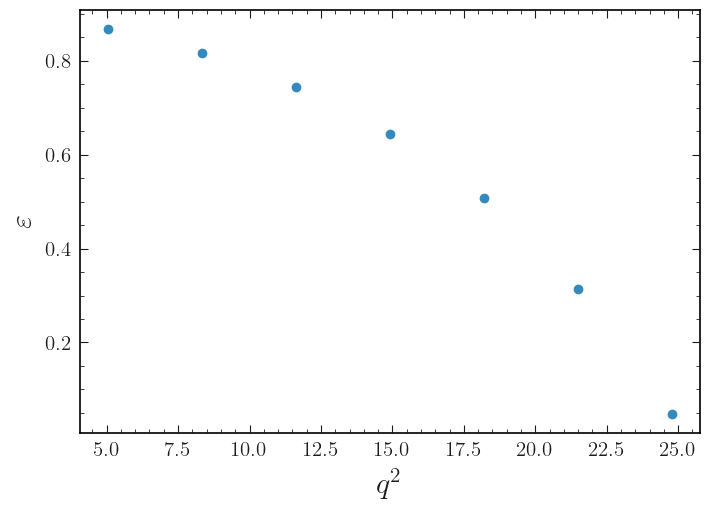

In [158]:
plt.plot(bin_cents, efficiency(bin_cents), "o")

plt.xlabel(r'$q^2$')
plt.ylabel(r'$\varepsilon$')
plt.show()

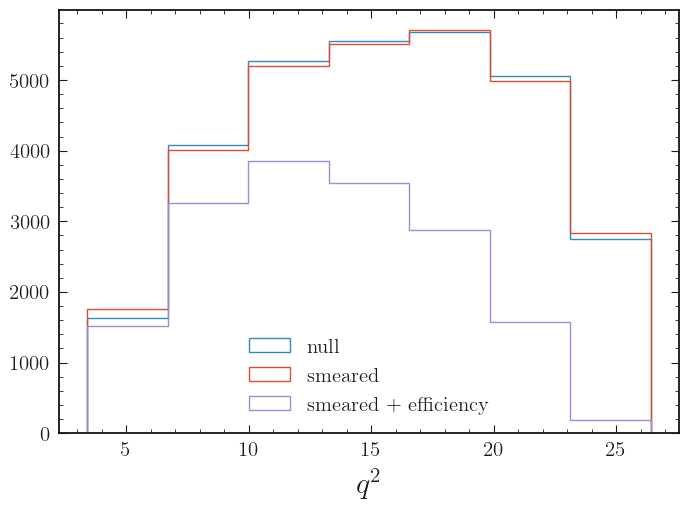

In [159]:
plt.hist(null_samples[:,0], fitbins, histtype='step', label='null')
plt.hist(null_samples_smeared[:,0], fitbins, histtype='step', label='smeared')
null_yields, _, _ = plt.hist(null_samples_smeared[:,0], fitbins, weights = efficiency(null_samples_smeared[:,0]), histtype='step', label='smeared + efficiency')

plt.xlabel(r'$q^2$')
plt.legend()

## Generate some fake data according to some NP model

Need to scale the number of samples here, because if NP would exist, we would also see a total different count of events.

In [160]:
p['ubtaunutau::Re{cVL}'].set(cvl)
p['ubtaunutau::Re{cVR}'].set(cvr)
p['ubtaunutau::Re{cSL}'].set(csl)
p['ubtaunutau::Re{cSR}'].set(csr)
p['ubtaunutau::Re{cT}' ].set(ctl)

BSMBR = obs.evaluate()

BSMsamples = int(SMsamples*BSMBR/SMBR)
alt_samples, pdf_values = pdf.sample_mcmc(BSMsamples, stride=5, pre_N=10000, preruns=5, cov_scale=0.1, rng=np.random.mtrand.RandomState(seed=1234))

Pre-runs:   0%|          | 0/5 [00:00<?, ?it/s]

Main run:   0%|          | 0/100 [00:00<?, ?it/s]

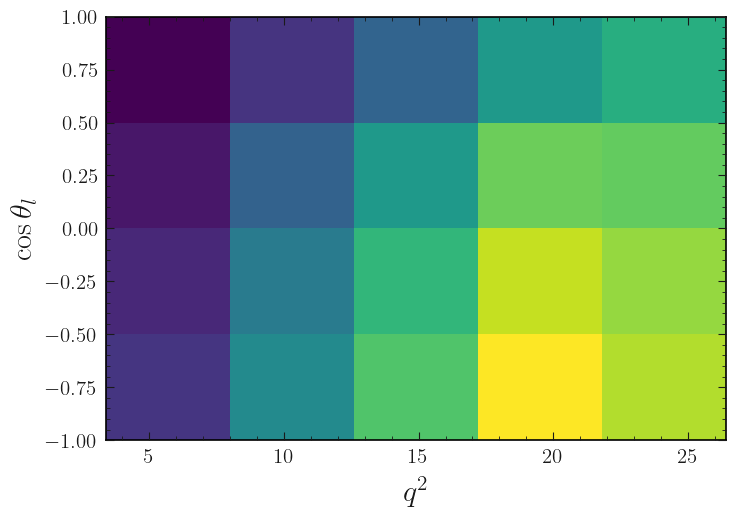

In [161]:
plt.hist2d(alt_samples[:,0], alt_samples[:,1], binning)
plt.xlabel(r'$q^2$')
plt.ylabel(r'$\cos\theta_l$')
plt.show()

In [162]:
alt_q2 = alt_samples[:,0]
alt_ct = alt_samples[:,1]

alt_q2_smeared = np.random.normal(alt_q2, 1.0, alt_q2.shape)
#map values outside of range of q2bins to the closest boundary
alt_q2_smeared = np.where(alt_q2_smeared>max(q2bins), max(q2bins), alt_q2_smeared)
alt_q2_smeared = np.where(alt_q2_smeared<min(q2bins), min(q2bins), alt_q2_smeared)

alt_ct_smeared = np.random.normal(alt_ct, 0.1, alt_ct.shape)
#map values outside of range of ctbins to the other side
alt_ct_smeared = np.where(alt_ct_smeared>max(ctbins), alt_ct_smeared-(max(ctbins)-min(ctbins)), alt_ct_smeared)
alt_ct_smeared = np.where(alt_ct_smeared<min(ctbins), alt_ct_smeared+(max(ctbins)-min(ctbins)), alt_ct_smeared)
alt_samples_smeared = np.stack((alt_q2_smeared, alt_ct_smeared), axis=1)

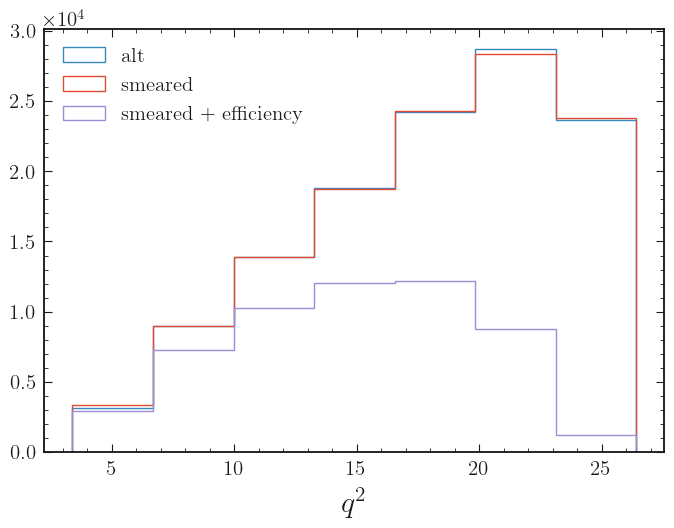

In [163]:
plt.hist(alt_samples[:,0], fitbins, histtype='step', label='alt')
plt.hist(alt_samples_smeared[:,0], fitbins, histtype='step', label='smeared')
alt_yields, _, _ = plt.hist(alt_samples_smeared[:,0], fitbins, weights = efficiency(alt_samples_smeared[:,0]), histtype='step', label='smeared + efficiency')

plt.xlabel(r'$q^2$')
plt.legend()

## Set up the mapping distribution

In [164]:
# mapping_dist = np.histogramdd([null_samples_smeared[:,0], null_samples[:,0], null_samples[:,1]], bins=[fitbins, q2bins, ctbins])[0]
mapping_dist = modifier.map(null_samples_smeared[:,0], [null_samples[:,0], null_samples[:,1]], fitbins, [q2bins, ctbins])

mapping_dist = mapping_dist * efficiency(bin_cents)[:,np.newaxis, np.newaxis]

## Set up the custom modifier

In [165]:
null = null_pred()
alt = alt_pred()

In [166]:
ana = analysis()

fp0 = ana.parameters['B->pi::alpha^f+_0@BSZ2015'].evaluate()
fp1 = ana.parameters['B->pi::alpha^f+_1@BSZ2015'].evaluate()
fp2 = ana.parameters['B->pi::alpha^f+_2@BSZ2015'].evaluate()
f01 = ana.parameters['B->pi::alpha^f0_1@BSZ2015'].evaluate()
f02 = ana.parameters['B->pi::alpha^f0_2@BSZ2015'].evaluate()
ft0 = ana.parameters['B->pi::alpha^fT_0@BSZ2015'].evaluate()
ft1 = ana.parameters['B->pi::alpha^fT_1@BSZ2015'].evaluate()
ft2 = ana.parameters['B->pi::alpha^fT_2@BSZ2015'].evaluate()

In [167]:
# Get covariance matrix of hadronic parameters
cov = parameter_cov(alt.ana)
pd.DataFrame(cov).style.background_gradient(cmap='RdBu')

Pre-runs:   0%|          | 0/5 [00:00<?, ?it/s]

Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Pre-runs:   0%|          | 0/5 [00:00<?, ?it/s]

Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Pre-runs:   0%|          | 0/5 [00:00<?, ?it/s]

Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Pre-runs:   0%|          | 0/5 [00:00<?, ?it/s]

Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Pre-runs:   0%|          | 0/5 [00:00<?, ?it/s]

Main run:   0%|          | 0/100 [00:00<?, ?it/s]

,0,1,2,3,4,5,6,7
0,0.000637,0.005924,0.010561,0.002754,0.003018,0.000180,0.009137,0.009632
1,0.005924,0.102319,0.203520,0.028295,0.033398,-0.005152,0.238005,0.309082
2,0.010561,0.203520,0.415794,0.051386,0.061610,-0.012101,0.491063,0.640306
3,0.002754,0.028295,0.051386,0.012833,0.014537,0.000400,0.048094,0.052101
4,0.003018,0.033398,0.061610,0.014537,0.016811,0.000108,0.060162,0.066692
5,0.000180,-0.005152,-0.012101,0.000400,0.000108,0.002329,-0.039874,-0.053011
6,0.009137,0.238005,0.491063,0.048094,0.060162,-0.039874,1.037669,1.077146
7,0.009632,0.309082,0.640306,0.052101,0.066692,-0.053011,1.077146,4.630286


In [168]:
new_params = {
                'cvl'   :{'inits': (1.00,), 'bounds': ((0., 2.),), 'paramset_type': 'unconstrained'},
                'cvr'   :{'inits': (0.00,), 'bounds': ((0., 2.),), 'paramset_type': 'unconstrained'},
                'csl'   :{'inits': (0.00,), 'bounds': ((0., 2.),), 'paramset_type': 'unconstrained'},
                'csr'   :{'inits': (0.00,), 'bounds': ((0., 2.),), 'paramset_type': 'unconstrained'},
                'ctl'   :{'inits': (0.00,), 'bounds': ((0., 2.),), 'paramset_type': 'unconstrained'},
                'FF'    :{'inits': (fp0, fp1, fp2, f01, f02, ft0, ft1, ft2), 
                         'bounds': (), 
                         'cov': cov, 
                         'paramset_type': 'constrained_by_normal'}
            }

cmod = modifier.Modifier(new_params, alt.distribution, null.distribution, mapping_dist, [q2bins, ctbins])

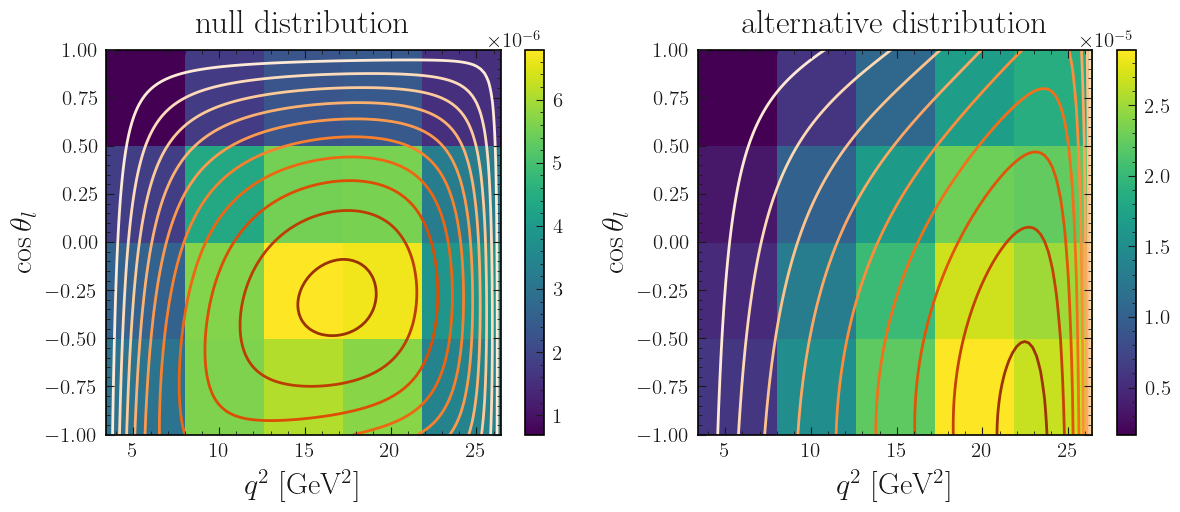

In [177]:
pars = (cvl, cvr, csl, csr, ctl, fp0, fp1, fp2, f01, f02, ft0, ft1, ft2)
labels = [r'$q^2$ [GeV$^2$]', r'$\cos\theta_l$']
plot.dists(cmod, pars, labels=labels, plot_dists=True);

(<Figure size 800x550 with 2 Axes>,
 <Axes: xlabel='Kinematic bins', ylabel='Fitting bins'>)

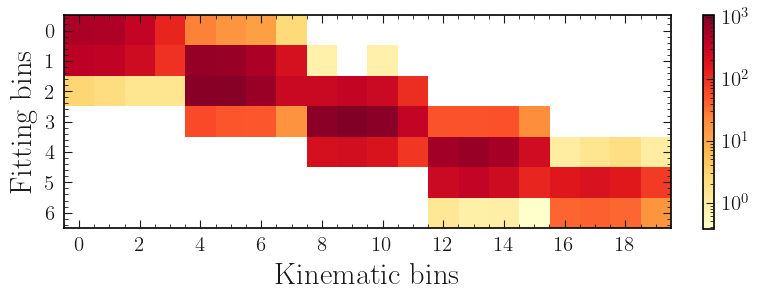

In [170]:
plot.map(cmod, cmap='YlOrRd', norm=LogNorm())

## Set up the model

In [171]:
spec = {
  "channels": [
    {
      "name": "singlechannel",
      "samples": [
        {
          "name": "signal",
          "data": null_yields.tolist(),
          "modifiers": [
            {
                "name": "mu",
                "type": "normfactor",
                "data": None
            },
            {
                "name": "stat",
                "type": "staterror",
                "data": np.sqrt(null_yields).tolist()
            }
          ]
        },
      ]
    }
  ]
}
model = pyhf.Model(spec)

custom_mod = {
                "name": "theory",
                "type": "custom",
                "data":
                    {
                        "expr": "custom_weight_fn",
                    }
              }

model = modifier.add_to_model(model, ['singlechannel'], ['signal'], cmod.expanded_pyhf, custom_mod)
model.spec

{'channels': [{'name': 'singlechannel',
   'samples': [{'name': 'signal',
     'data': [1515.720806199206,
      3261.639602181792,
      3854.670310514942,
      3541.275717653183,
      2883.0583973781886,
      1573.8037878562736,
      193.07192744575514],
     'modifiers': [{'name': 'mu', 'type': 'normfactor', 'data': None},
      {'name': 'stat',
       'type': 'staterror',
       'data': [38.93225919721595,
        57.11076607945118,
        62.085991258213326,
        59.50861885183677,
        53.69411883417204,
        39.67119594688662,
        13.895032473720784]},
      {'name': 'theory',
       'type': 'custom',
       'data': {'expr': 'custom_weight_fn'}}]}]}]}

## Save and load model

In [176]:
modifier.save('pilnu_model.json', model.spec, cmod, alt_yields)
model, alt_yields = modifier.load('pilnu_model.json', alt.distribution, null.distribution, return_data=True)

data = alt_yields + model.config.auxdata

## Perform the fit

In [173]:
fixed = model.config.suggested_fixed()
fixed[model.config.par_map['mu']['slice']] = [True]
fixed[model.config.par_map['cvr']['slice']] = [True]
fixed[model.config.par_map['csr']['slice']] = [True]
fixed[model.config.par_map['ctl']['slice']] = [True]

# for i in range(0, 8):
#     fixed[model.config.par_map[f'FF_decorrelated[{i}]']['slice']] = [True]

pyhf.set_backend("numpy", pyhf.optimize.scipy_optimizer())
best_fit = pyhf.infer.mle.fit(data, model, fixed_params=fixed)
pyhf.set_backend("numpy", pyhf.optimize.minuit_optimizer(verbose=True, strategy=2))
best_fit, twice_nll, OptimizeResult = pyhf.infer.mle.fit(
    data,
    model,
    init_pars=best_fit.tolist(),
    fixed_params=fixed,
    return_uncertainties=True,
    return_fitted_val=True,
    return_result_obj=True
    )

best_fit_dict = modifier.par_dict(model, best_fit)
best_fit_dict


{'cvl': array([0.94627579, 0.15084007]),
 'cvr': array([0., 0.]),
 'csl': array([1.01337877, 0.07390474]),
 'csr': array([0., 0.]),
 'ctl': array([0., 0.]),
 'FF_decorrelated[0]': array([0.08067654, 0.95075138]),
 'FF_decorrelated[1]': array([0.04749124, 0.96622121]),
 'FF_decorrelated[2]': array([-0.03515731,  0.9877026 ]),
 'FF_decorrelated[3]': array([-0.21951451,  0.91885121]),
 'FF_decorrelated[4]': array([-0.04373638,  0.99238232]),
 'FF_decorrelated[5]': array([0.00383814, 0.9840391 ]),
 'FF_decorrelated[6]': array([0.01055079, 0.975396  ]),
 'FF_decorrelated[7]': array([0.01763792, 0.98492383]),
 'mu': array([1., 0.]),
 'stat': [[1.0060509397382034, 0.02005932435391955],
  [0.9888991414574859, 0.013218392041052685],
  [0.9989532821415948, 0.011207652089385789],
  [1.0229836552292946, 0.011459657842099014],
  [0.9838738285120299, 0.013117147351279557],
  [0.9785757350037348, 0.018112695297783254],
  [1.126436993913764, 0.03678557463631249]]}

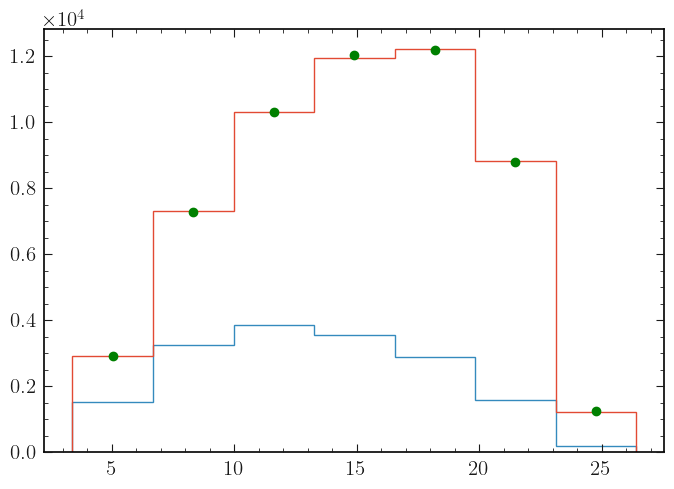

In [174]:
plt.stairs(model.expected_actualdata(model.config.suggested_init()), fitbins)
plt.stairs(model.expected_actualdata(best_fit[:,0]), fitbins)
bin_cents = (np.array(fitbins)[:-1] + np.array(fitbins)[1:])/2
plt.plot(bin_cents, alt_yields, 'og')

In [175]:
SMBR

7.871473217392401e-05